In [1]:
%run lgs03a_data_unification.ipynb

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
def load_predictions_data():
    predictions = pd.read_csv(os.path.join(data_folder, 'predictions','experimentally_tested_predictions.csv'))
    fiji_ctrls = {'cgre_wt': 246, 'cgre_neg': 5, 'amac_wt': 65, 'amac_neg': 4, 'pplu_wt': 191, 'pplu_neg': 4}
    predictions['fiji_log_value'] = np.log10(predictions['fiji_value'])
    
    predictions['fiji_log_scaled'] = predictions[['fiji_log_value', 'gene']].apply(lambda x:
                                        (x[0] - np.log10(fiji_ctrls[x[1]+'_neg'])) / 
                            (np.log10(fiji_ctrls[x[1]+'_wt']) -  np.log10(fiji_ctrls[x[1]+'_neg'])), axis=1)
    
    predictions['fiji_log_scaled'] = predictions['fiji_log_scaled'].apply(lambda x: x if x>0 else 0)
    
    minval = {gene : data_aa[data_aa.gene==gene]['brightness'].min() 
              for gene in ['amacGFP', 'cgreGFP', 'ppluGFP', 'avGFP']}
    print(minval)
    predictions['fiji_library_values'] = predictions[['fiji_log_scaled', 'gene']].apply(lambda x:
                                    x[0] * (ref_wt_log[x[1]+'GFP'] - minval[x[1]+'GFP']) + minval[x[1]+'GFP']
                                                                                  , axis=1    )
    
    return predictions

In [4]:
predictions = load_predictions_data()

{'amacGFP': 2.6522463410033232, 'cgreGFP': 2.7708520116421442, 'ppluGFP': 2.7708520116421442, 'avGFP': 1.283419239}


In [5]:
predictions['fraction_nonextant'] = predictions['non_extant_muts'] / predictions['distance']

# Diversity of ML genotypes

In [6]:
def hm_hamming_distance(gene, nmuts, dataset=predictions):
    df = predictions[(predictions.gene == gene) & (predictions.distance == nmuts)]
    d = dict(zip(df['sq_name'], df['full_seq']))
    names = list(d.keys())
    
    df = pd.DataFrame()
    for i in range(len(d)):
        for j in range(len(d)):
            seq1, seq2 = d[names[i]], d[names[j]]
            ham = sum([1 for a,b in zip(seq1,seq2) if a!=b])
            df.loc[names[i], names[j]] = ham
            df.loc[names[j], names[i]] = ham
            
    return df

### amacGFP

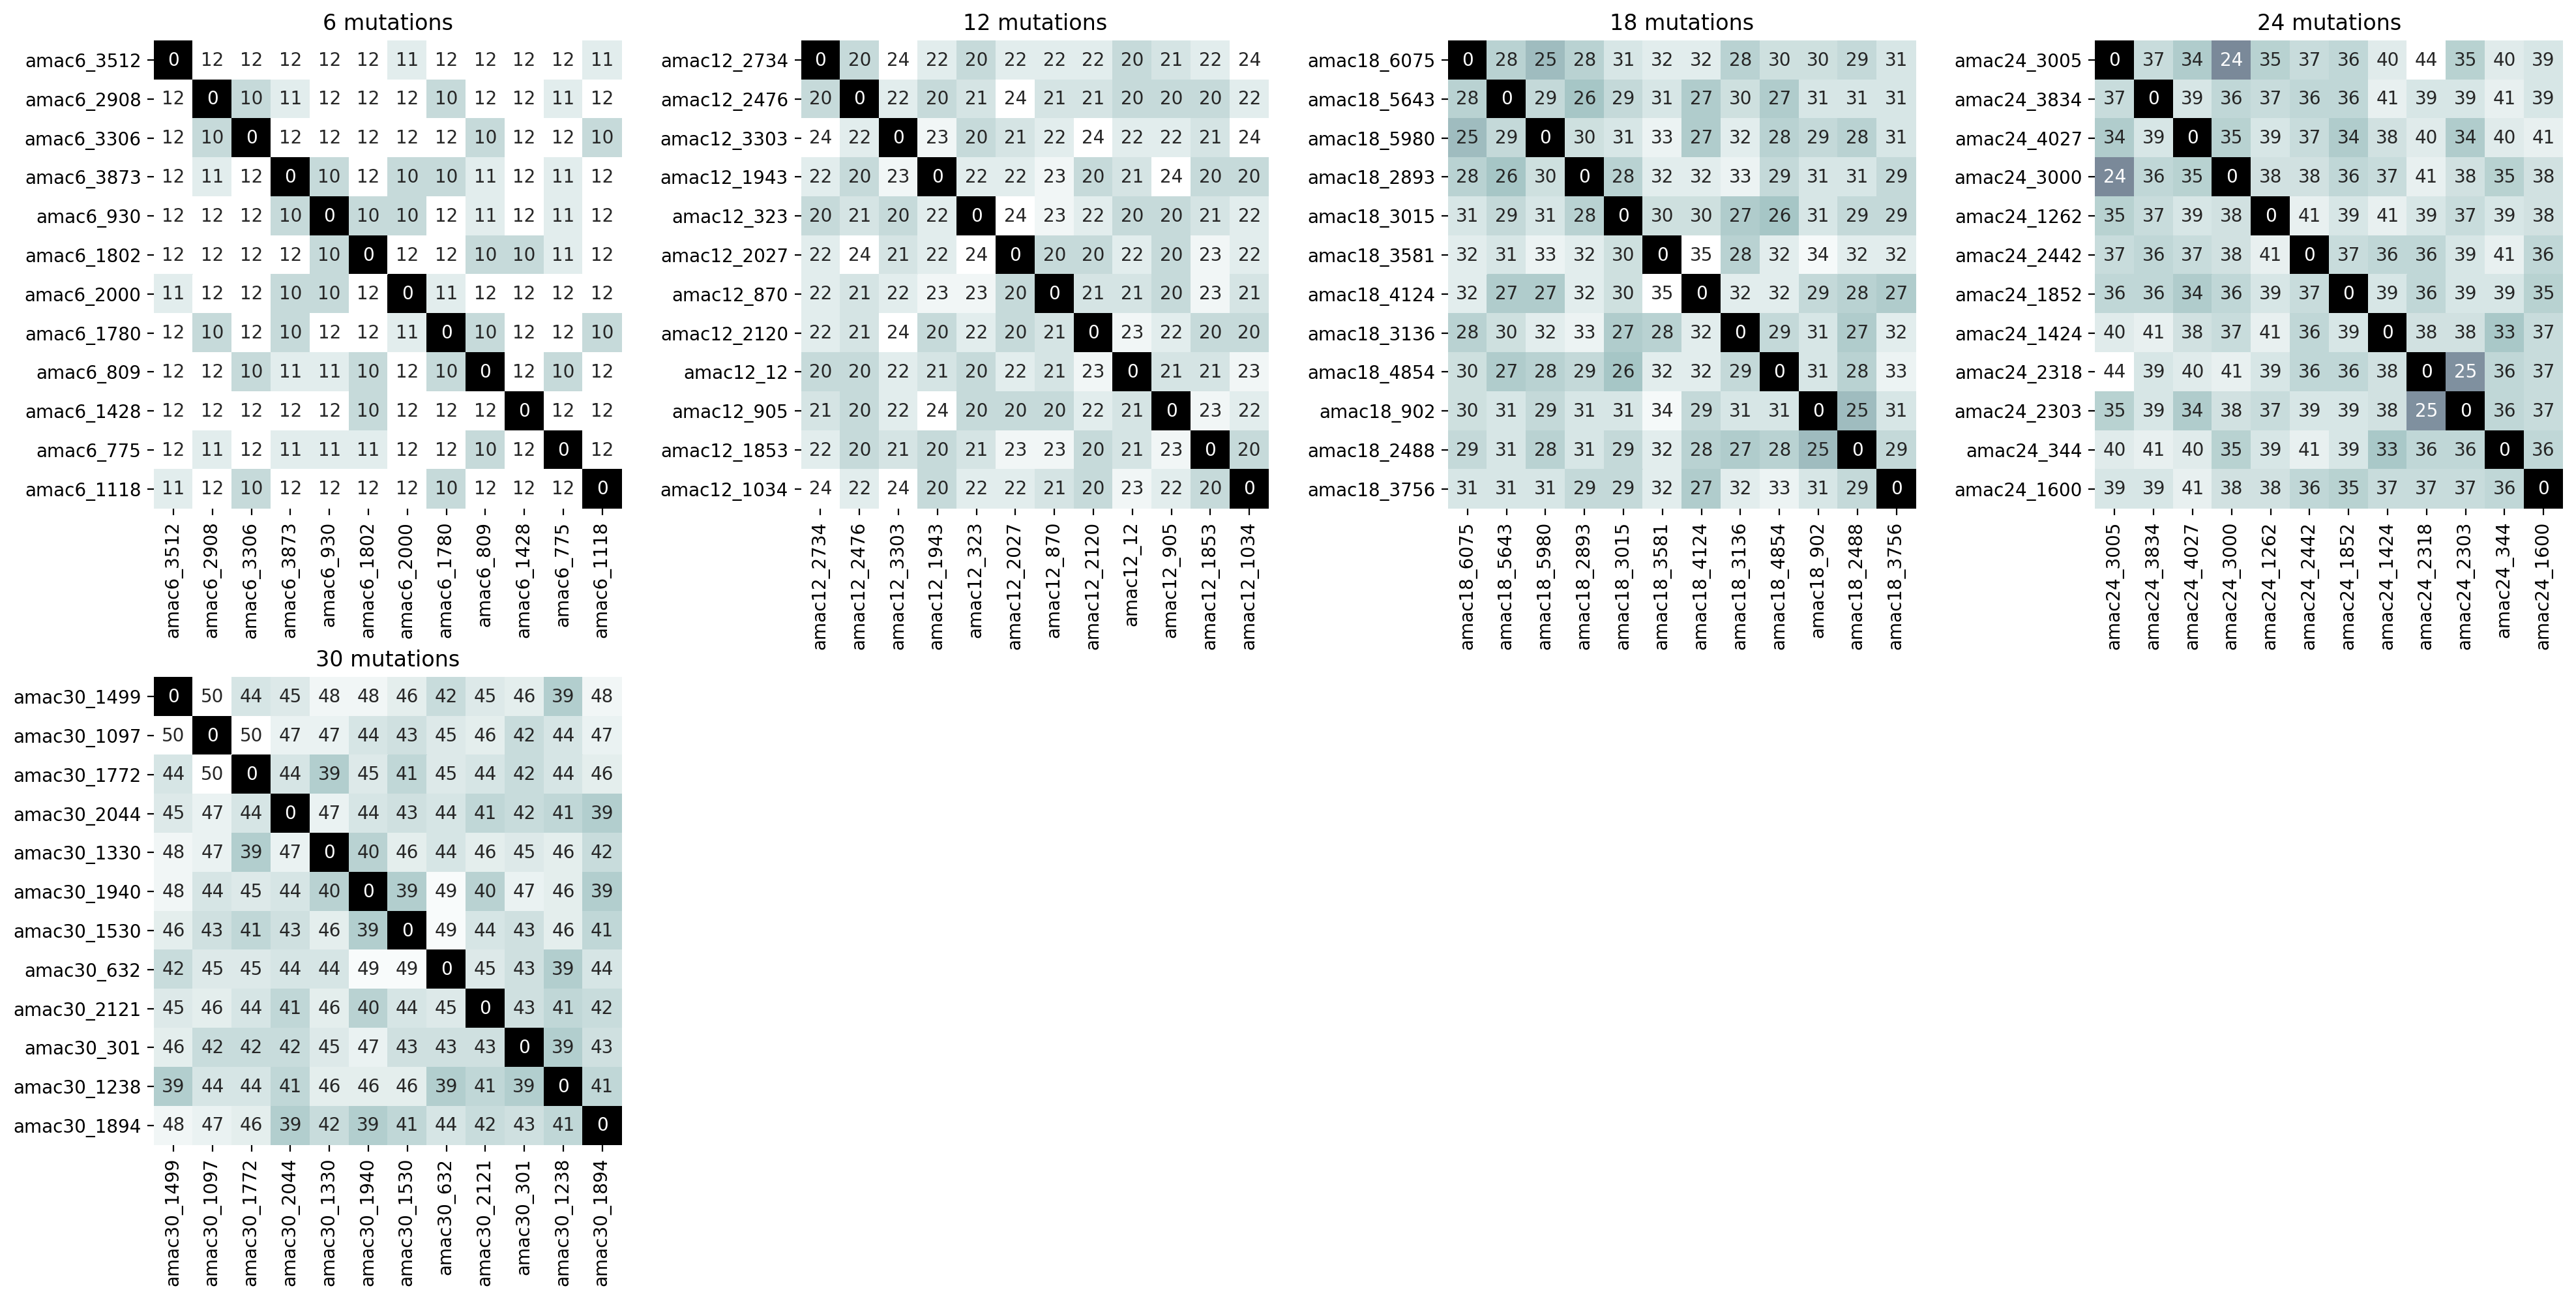

In [7]:
axes = subplots(nplots=5, nplots_per_row=4, height=5, width=5)

for ax,nmut in zip(axes, [6,12,18,24,30]):
    plt.sca(ax)
    array = hm_hamming_distance('amac', nmut)
    sns.heatmap(array, square = True, annot = True, fmt='g', cbar=False, cmap='bone')
    plt.title(f'{nmut} mutations')
plt.tight_layout()

### ppluGFP

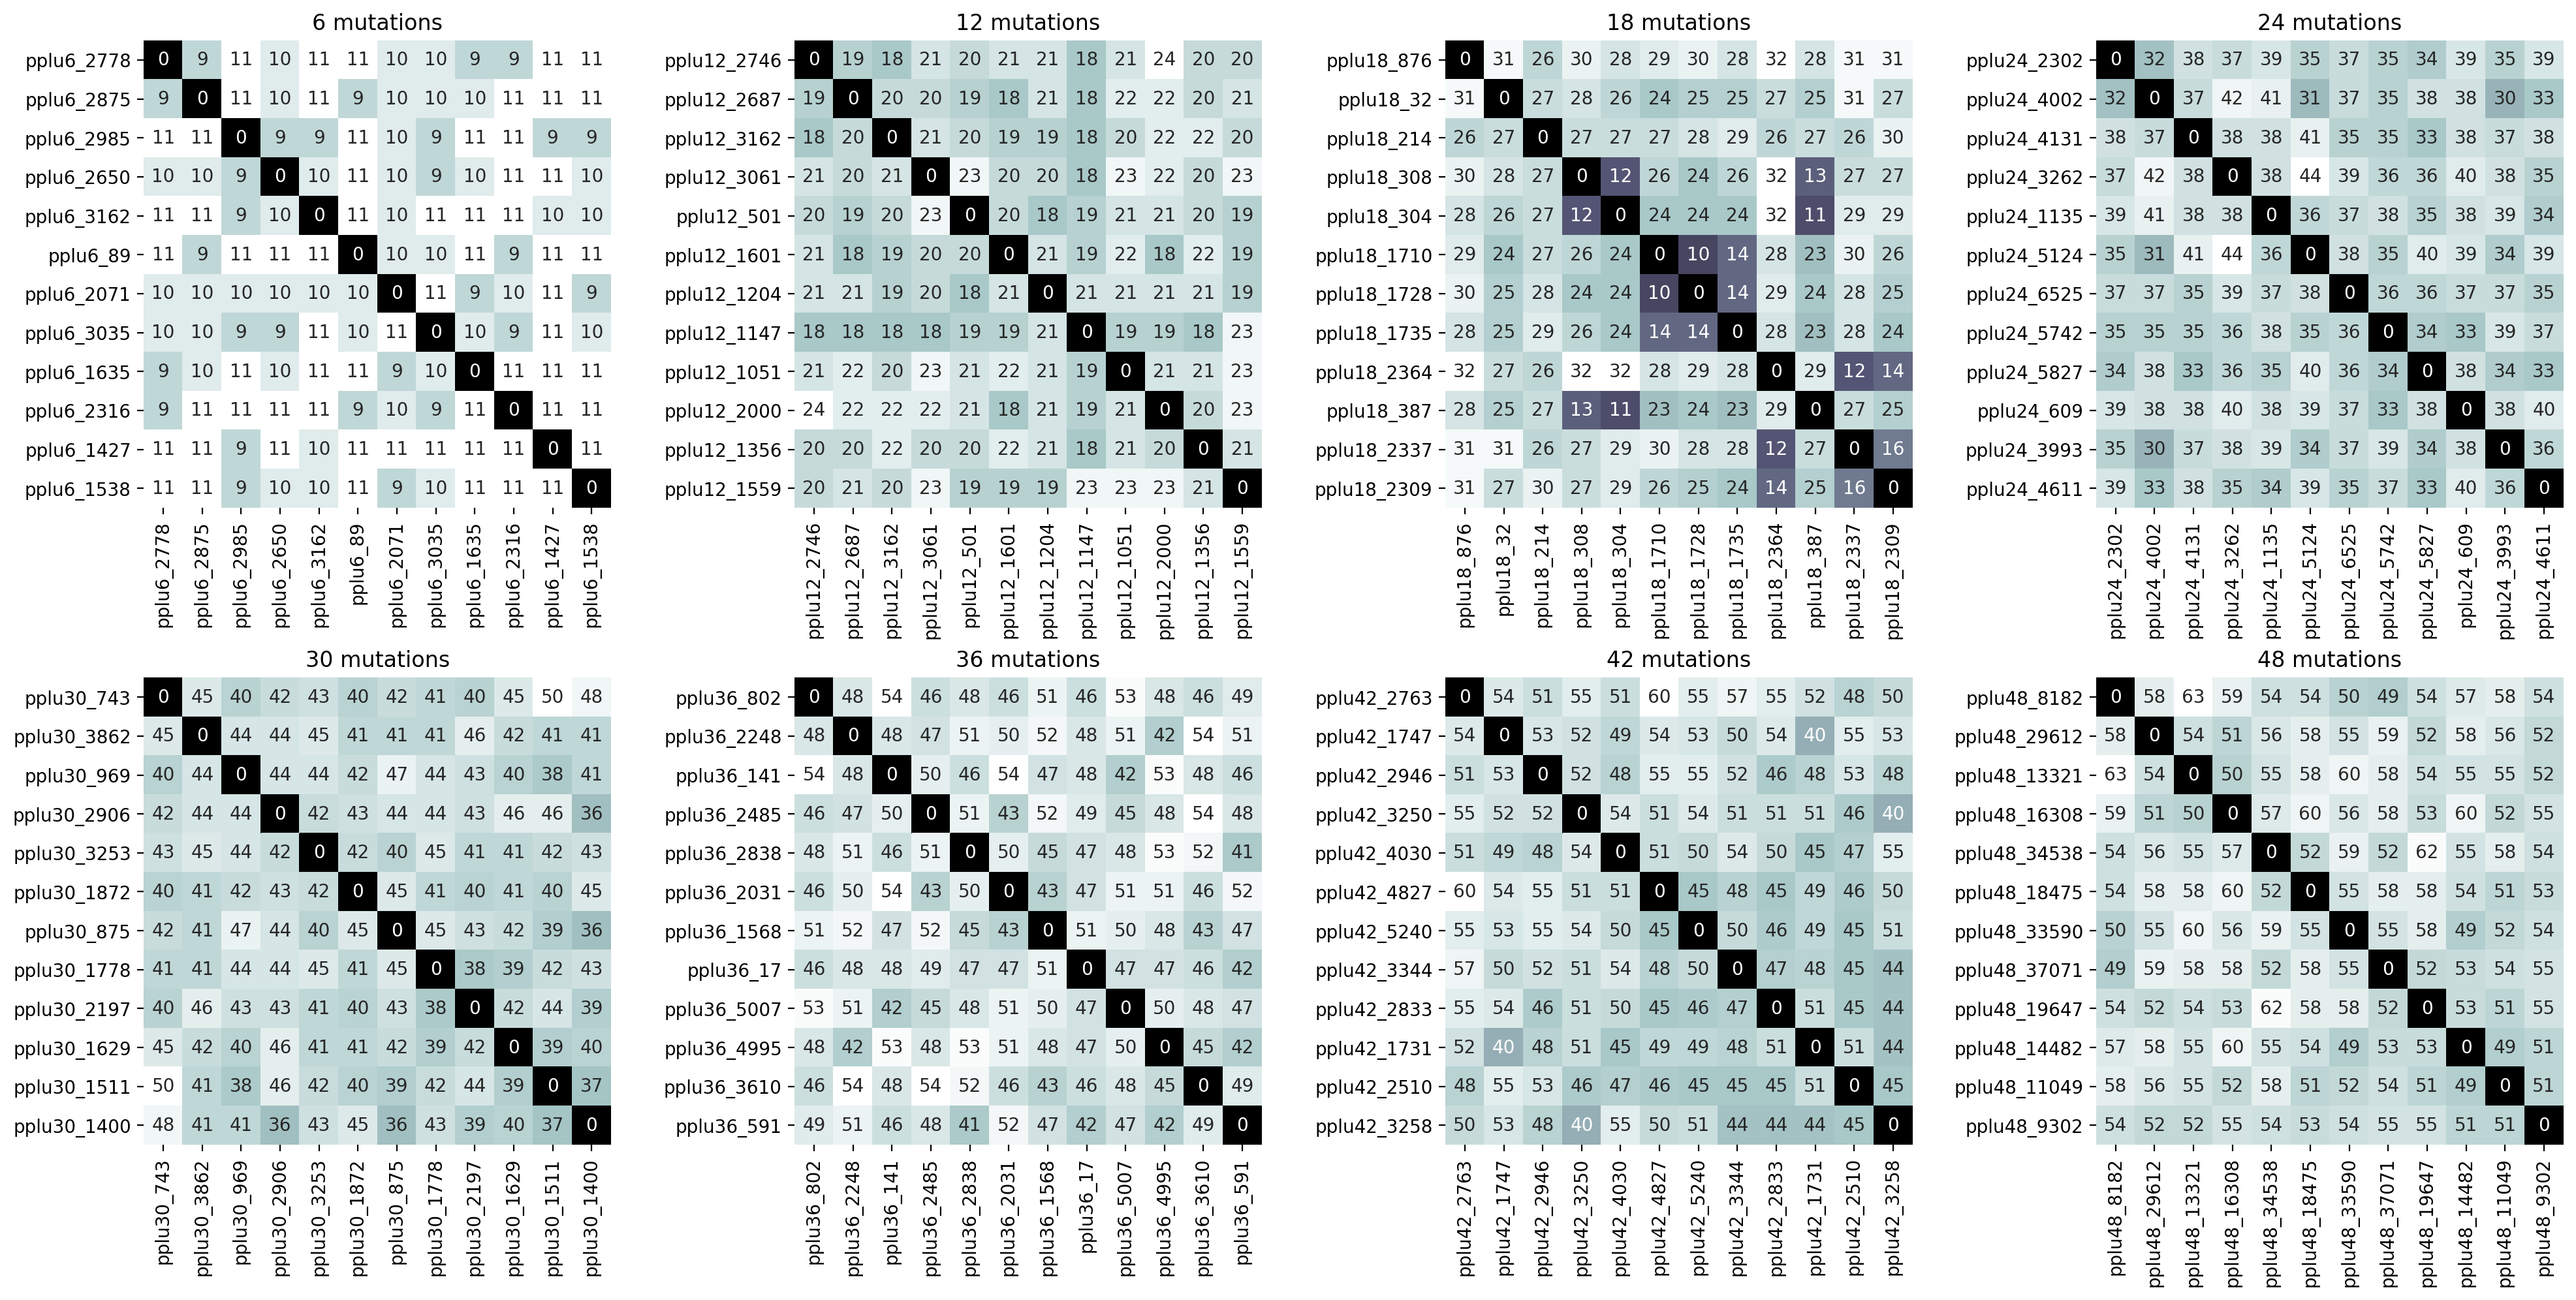

In [8]:
axes = subplots(nplots=8, nplots_per_row=4, height=5, width=5)

for ax,nmut in zip(axes, [6,12,18,24,30,36,42,48]):
    plt.sca(ax)
    array = hm_hamming_distance('pplu', nmut)
    sns.heatmap(array, square = True, annot = True, fmt='g', cbar=False, cmap='bone')
    plt.title(f'{nmut} mutations')
plt.tight_layout()

### cgreGFP

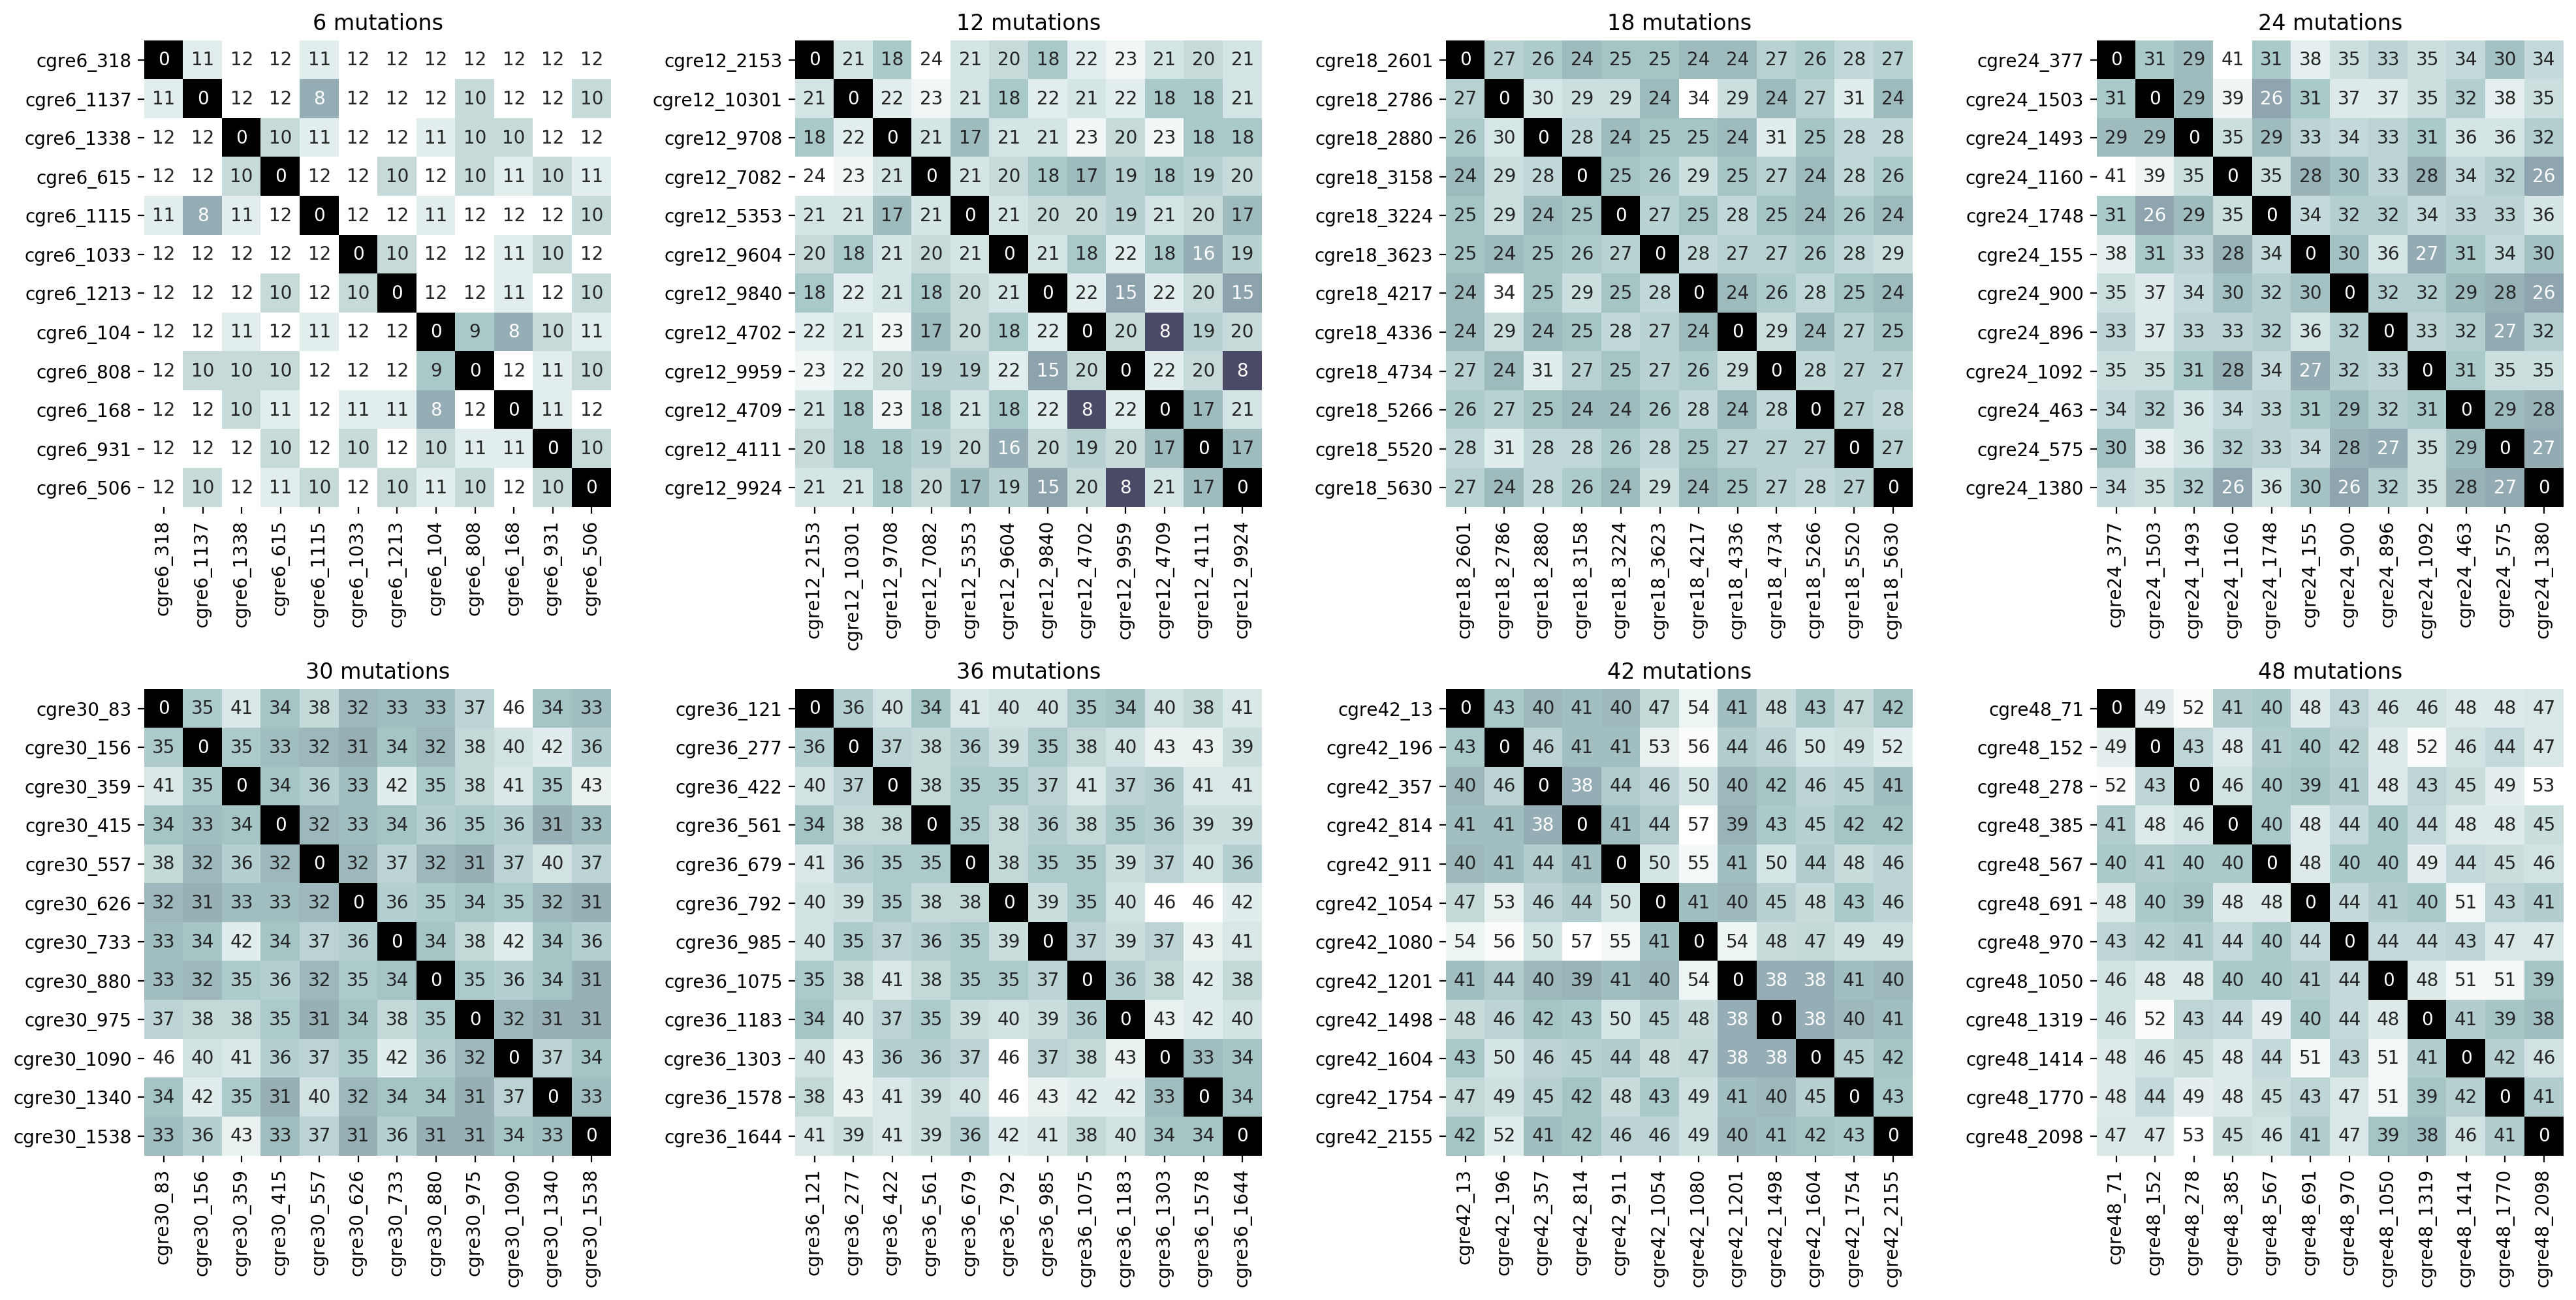

In [9]:
axes = subplots(nplots=8, nplots_per_row=4, height=5, width=5)

for ax,nmut in zip(axes, [6,12,18,24,30,36,42,48]):
    plt.sca(ax)
    array = hm_hamming_distance('cgre', nmut)
    sns.heatmap(array, square = True, annot = True, fmt='g', cbar=False, cmap='bone')
    plt.title(f'{nmut} mutations')
plt.tight_layout()

# Comparison between genes

(-0.5, 8)

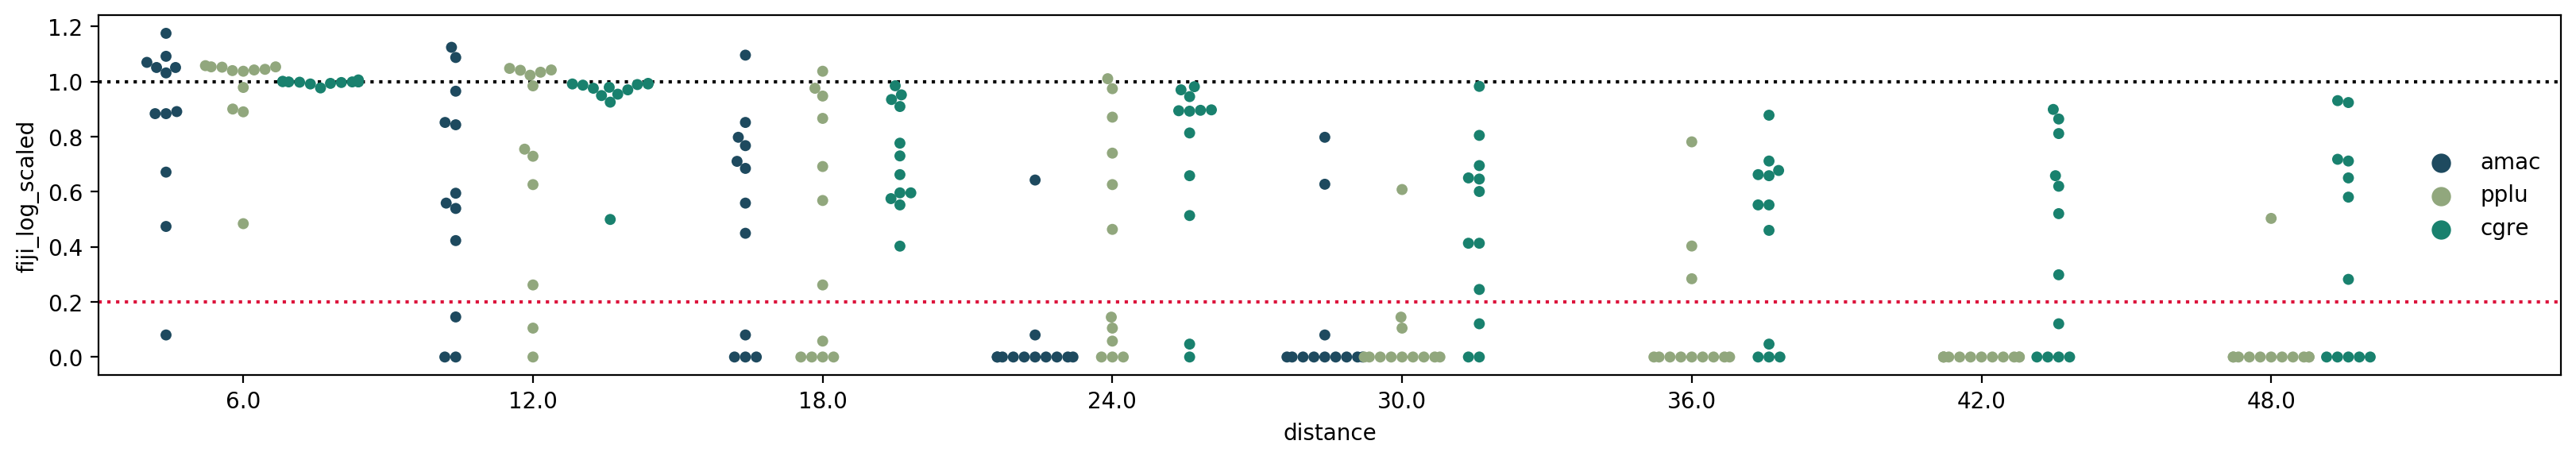

In [10]:
plt.figure(figsize=[20,3], dpi=200)
plt.axhline(1, linestyle=':', color='k')
plt.axhline(0.2, linestyle=':', color='crimson')
ax = sns.swarmplot(data=predictions, x='distance', y='fiji_log_scaled', hue='gene', size=5,
                   palette = [colors['amac'], colors['pplu'], colors['cgre']], dodge=True)
plt.legend(loc='center right', frameon=False)
plt.xlim(-0.5,8)

# Extant and non-extant mutations

In [11]:
def distance_fitness_extant_swarm(gene):
    plt.figure(figsize=[20,3], dpi=200)
    plt.axhline(1, linestyle=':', color='k') # wildtype level
    plt.axhline(0.2, linestyle=':', color='crimson') # non-fluorescence threshold
    ax = sns.swarmplot(data=predictions[predictions.gene == gene], 
                       x='distance', y='fiji_log_scaled', hue='fraction_nonextant', size=5, palette = 'mako', )
    ax.get_legend().remove()
    plt.xlim(-0.5,7.5)
    label_plot_axis(t=gene+'GFP', x='Number of mutations', y='Brightness')

    #colormap hack
    col = predictions[predictions.gene == gene]['fraction_nonextant']
    plt.scatter([x-10 for x in col], col, c=col, cmap='mako')
    plt.colorbar(pad=0.01).set_label('Fraction of mutations\nwhich are non-extant')

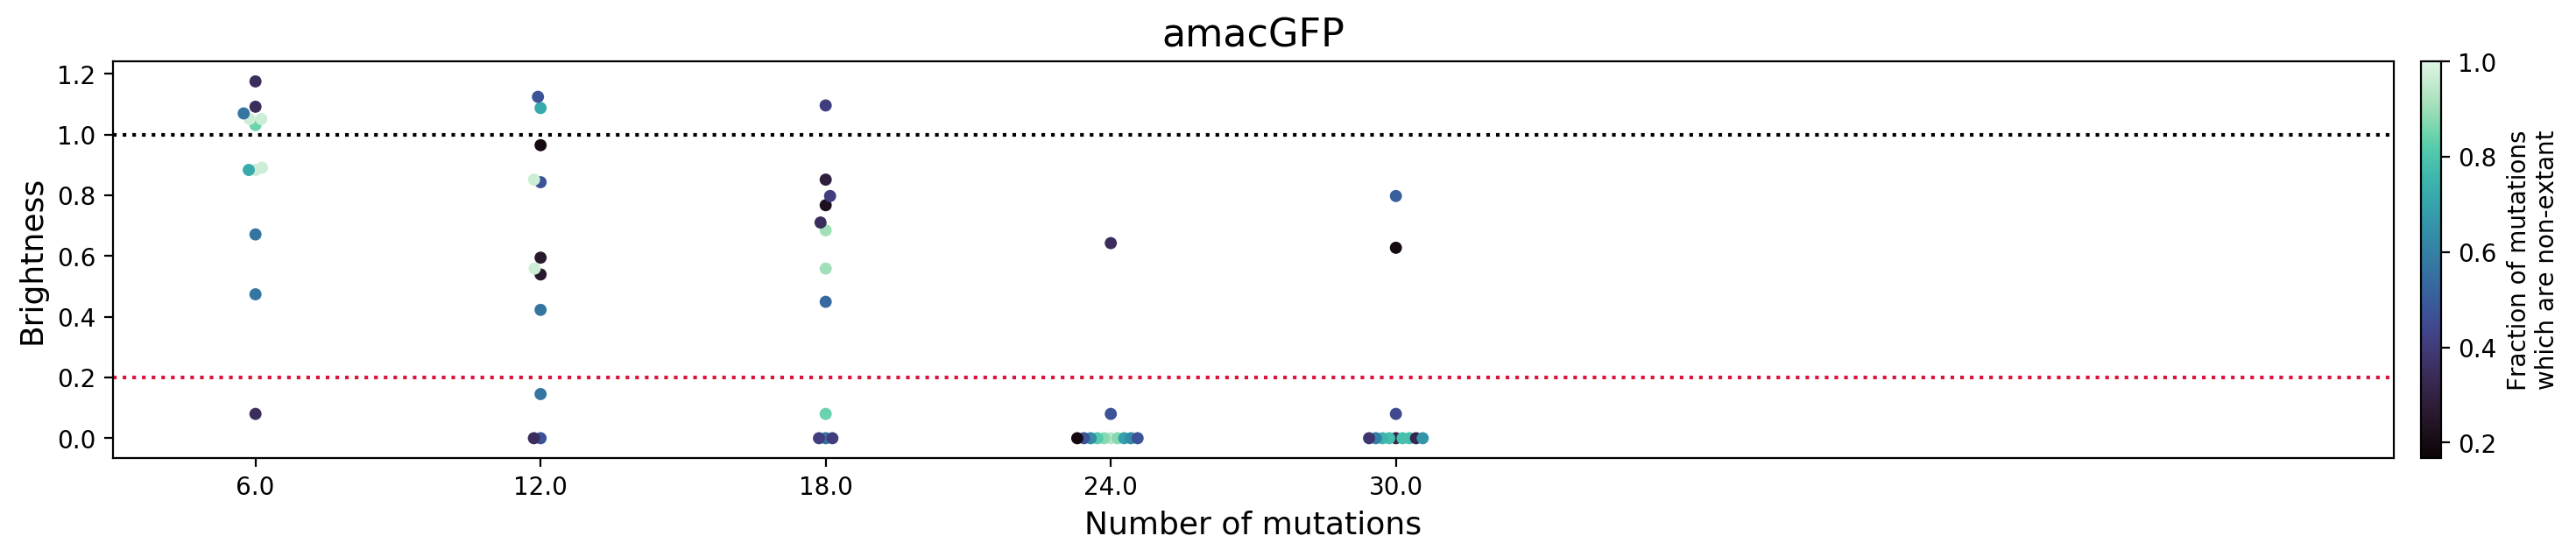

In [101]:
distance_fitness_extant_swarm('amac')

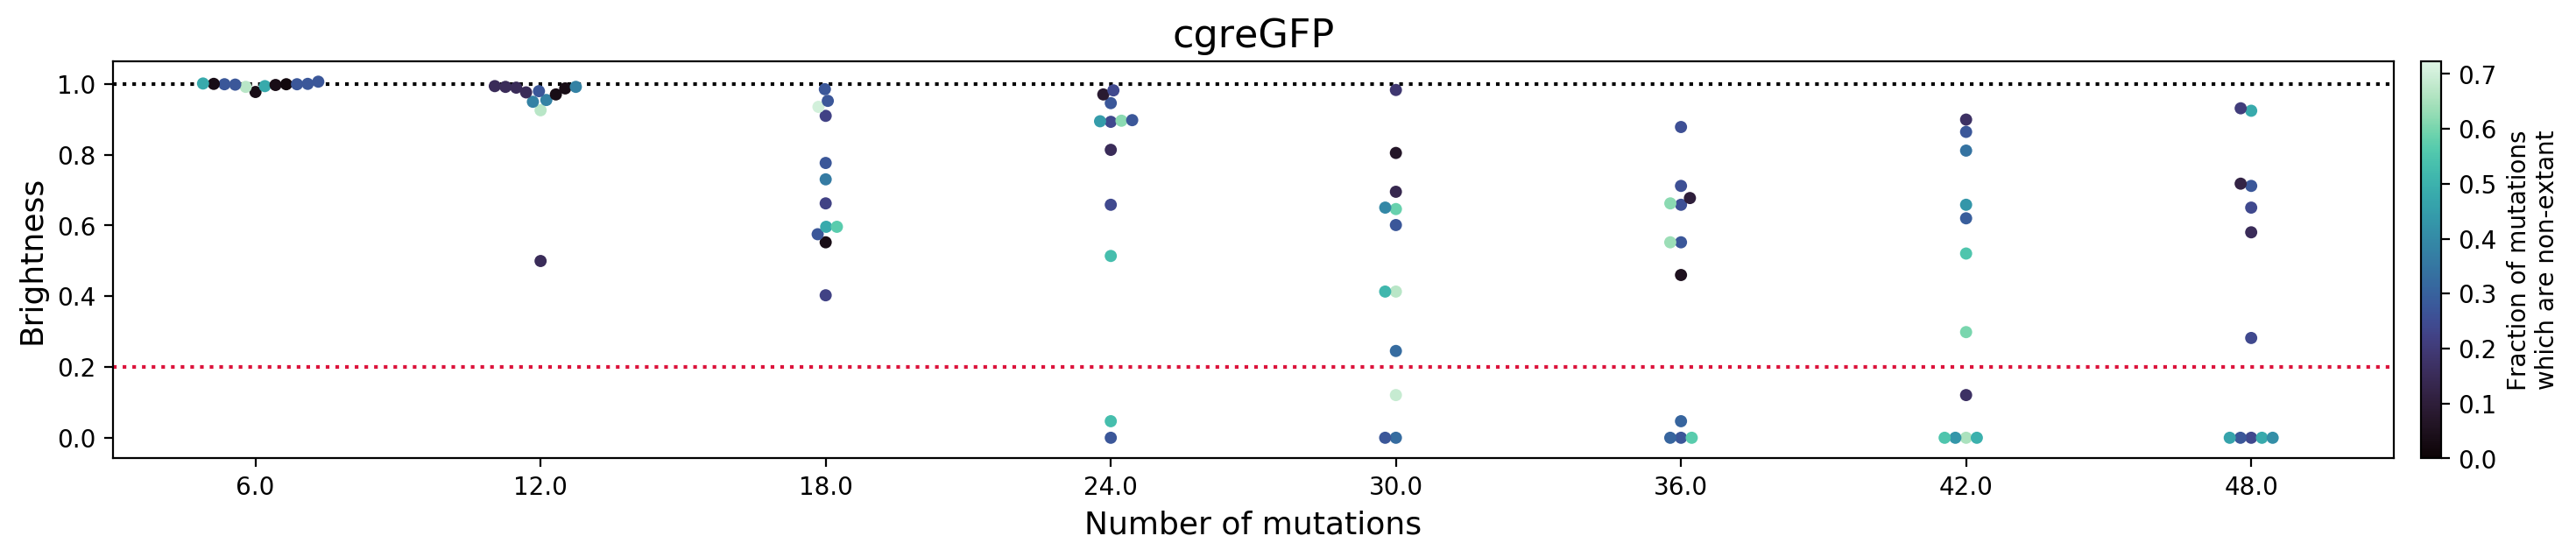

In [102]:
distance_fitness_extant_swarm('cgre')

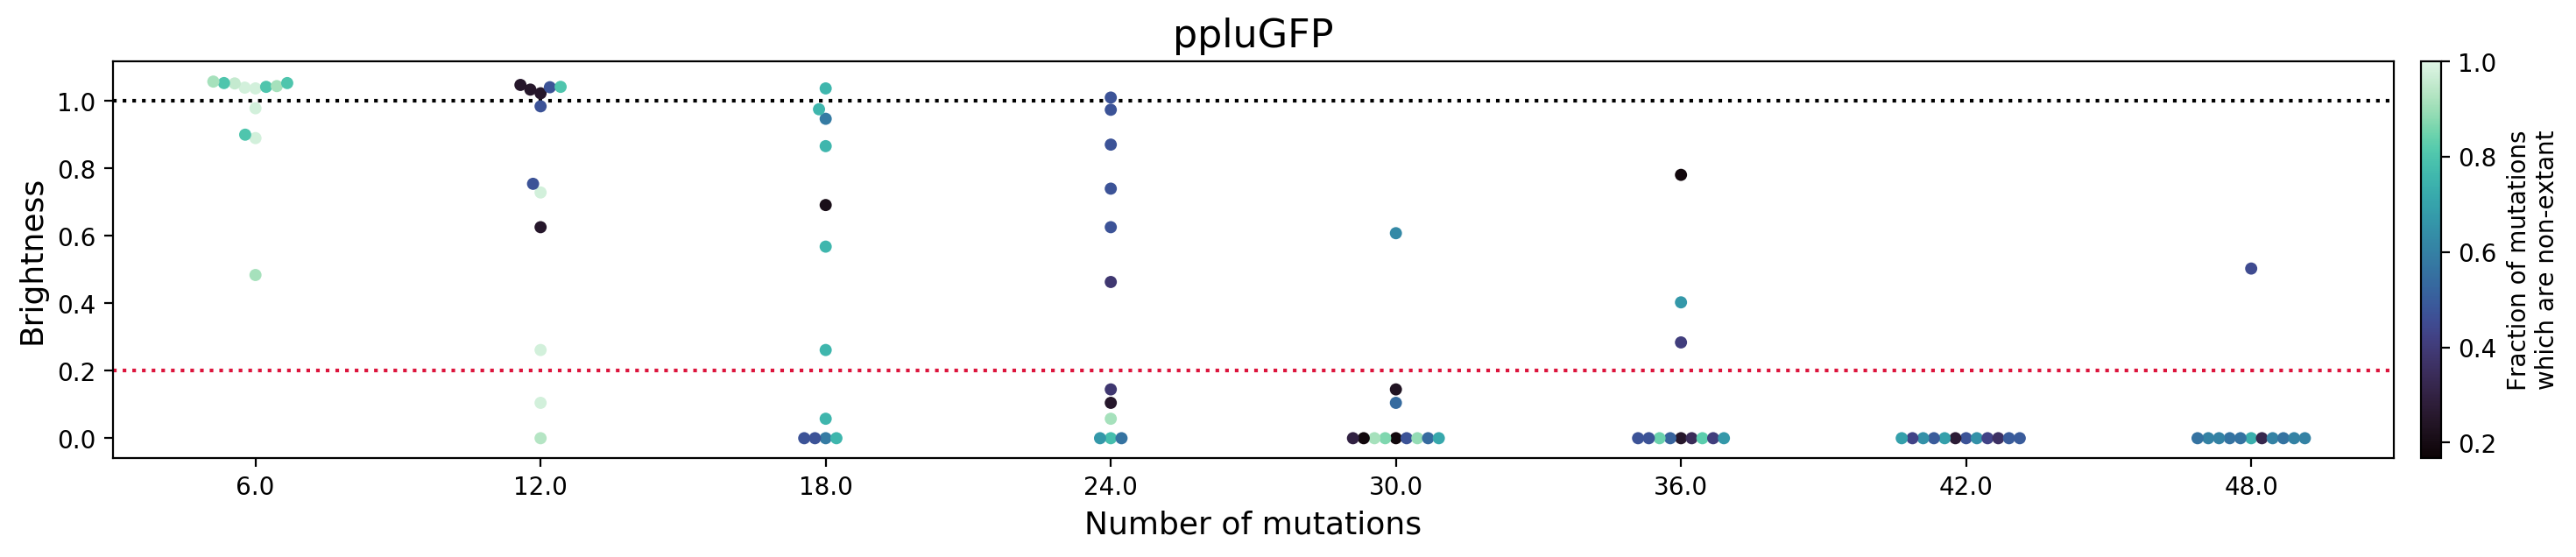

In [103]:
distance_fitness_extant_swarm('pplu')

# Conditionally deleterious mutations

In [ ]:
import pickle
bg_data = pickle.load(open('mutation_effects_by_background_log10.pkl', 'rb'))

### Hand-picked "best" mutations: 12 genotypes with 24 mutations (non-ML)

''

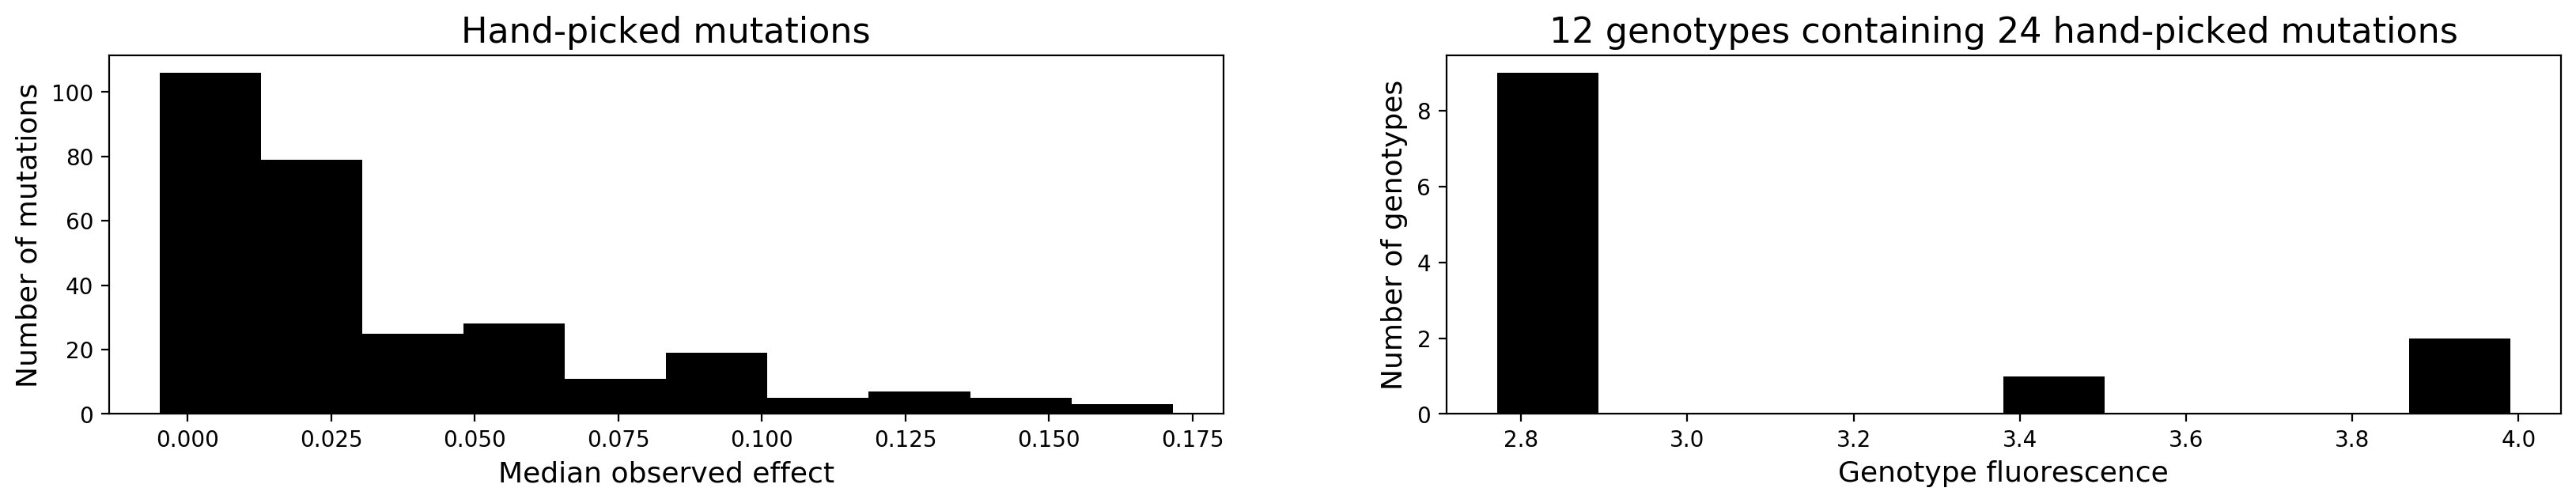

In [59]:
hand = ':'.join(predictions[predictions.sq_name.str.contains('top')]['aa_genotype_pseudo']).split(':')
medians = [bg_data['ppluGFP'][mut]['mut_effect'].median() for mut in hand 
                               if mut in bg_data['ppluGFP']]

plt.figure(figsize=[20,3],dpi=200)
plt.subplot(1,2,1)
plt.hist(medians, color='k')
label_plot_axis(x = 'Median observed effect', y = 'Number of mutations', t = 'Hand-picked mutations')

plt.subplot(1,2,2)
plt.hist(predictions[predictions.sq_name.str.contains('top')]['fiji_library_values'], color='k')
label_plot_axis(x = 'Genotype fluorescence', y = 'Number of genotypes', 
                t = '12 genotypes containing 24 hand-picked mutations')
;

### Negative epistasis in ML genotypes

In [16]:
all_mutations = {gene : set(':'.join(predictions[predictions.gene==gene]['aa_genotype_pseudo']).split(':'))
                for gene in ['amac','cgre','pplu']}

In [17]:
def get_expected_effect_bg(muts_str, siffects_dict, min_brightness, max_brightness):
    muts = muts_str.split(':')
    expectation = 0 
    try:
        for m in muts:
            expectation += siffects_dict[m]['mut_effect'].median()
        if expectation > max_brightness:
            return max_brightness
        elif expectation < min_brightness:
            return min_brightness
        else:
            return expectation
    except:
        return np.nan

In [18]:
predictions['additive_expectation'] = predictions[['gene', 'aa_genotype_pseudo']].apply(lambda x:
                                            get_expected_effect(x[1], eval(f'siffects_{x[0]}_log'),
                                min_brightness = data_aa[data_aa.gene==x[0]+'GFP']['brightness'].min() - ref_wt_log[x[0]+'GFP'],
                                max_brightness = data_aa[data_aa.gene==x[0]+'GFP']['brightness'].max() - ref_wt_log[x[0]+'GFP'])
                                                                                        + ref_wt_log[x[0]+'GFP'],
                                                                                       axis=1)

In [19]:
predictions['additive_expectation_bg'] = predictions[['gene', 'aa_genotype_pseudo']].apply(lambda x:
                                            get_expected_effect_bg(x[1], bg_data[x[0]+'GFP'],
                                min_brightness = data_aa[data_aa.gene==x[0]+'GFP']['brightness'].min() - ref_wt_log[x[0]+'GFP'],
                                max_brightness = data_aa[data_aa.gene==x[0]+'GFP']['brightness'].max() - ref_wt_log[x[0]+'GFP'])
                                                                                        + ref_wt_log[x[0]+'GFP'],
                                                                                       axis=1)

In [20]:
predictions['epistasis'] = predictions['fiji_library_values'] - predictions['additive_expectation']

In [21]:
predictions['epistasis_bg'] = predictions['fiji_library_values'] - predictions['additive_expectation_bg']

amac 60
Genotypes with |epistasis| > 0.3:  0.78
Genotypes with |epistasis| > 1:  0.46 

pplu 108
Genotypes with |epistasis| > 0.3:  0.81
Genotypes with |epistasis| > 1:  0.65 

cgre 96
Genotypes with |epistasis| > 0.3:  0.57
Genotypes with |epistasis| > 1:  0.21 



''

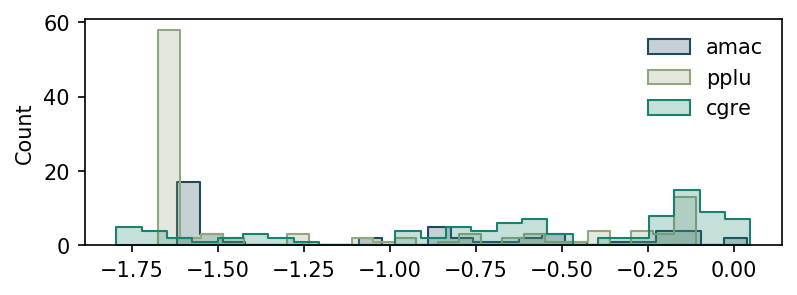

In [22]:
plt.figure(figsize=[6,2], dpi=150)

for gene in ['amac','pplu','cgre']:
    d = list(predictions[predictions.gene==gene]['epistasis_bg'])
    notnull = len(predictions[(predictions.gene==gene) & (predictions.epistasis_bg.notnull())])
    
    sns.histplot(data = d, element='step',
            label=gene, alpha=0.25, bins=25, color=colors[gene])
    
    print(gene, len(d))
    print('Genotypes with |epistasis| > 0.3: ', 
                 round(len([x for x in d if  abs(x) > 0.3]) / notnull, 2))
    print('Genotypes with |epistasis| > 1: ', 
                 round(len([x for x in d if abs(x) > 1]) / notnull, 2), '\n')

plt.legend(frameon=False)
;

### Conditionally deleterious (CD) mutations in functional ML genotypes

In [23]:
def plot_percent_cond_del_muts(genes, e=-0.3, fitmin='WT-bright'):
    values = { gene : 0 for gene in genes }
    stds = {'amac':0.031, 'cgre':0.028, 'pplu':0.027}
    sel = {}
    
    # all mutations incorporated in any ML genotype
    all_mutations = {gene : set(':'.join(predictions[predictions.gene==gene]['aa_genotype_pseudo']).split(':'))
                for gene in ['amac','cgre','pplu']}
    print('\n', fitmin)
    for gene in genes:
        if fitmin == 'WT-bright':
            fitness_min = ref_wt_log[f'{gene}GFP'] - stds[gene]*2
        elif fitmin == 'functional':
            fitness_min = gate_borders_log[gene][1]
            
        # selected = mutations which were used in successful ML predictions
        selected = set(':'.join(predictions[(predictions.gene == gene) & 
                                            (predictions.fiji_library_values > fitness_min) 
                                           ]['aa_genotype_pseudo']).split(':'))
        
        flippers_all = [] # conditionally deleterious mutations found in any ML genotype 
        flippers_successful = [] # conditionally deleterious mutations found in successful ML genotypes
        
        for mut in all_mutations[gene]:
            if mut in bg_data[gene+'GFP'] and min(bg_data[gene+'GFP'][mut]['mut_effect']) < e:
                flippers_all.append(mut)
                
        for mut in selected:
            if mut in bg_data[gene+'GFP'] and min(bg_data[gene+'GFP'][mut]['mut_effect']) < e:
                flippers_successful.append(mut)
                
        print(gene)
        print('% mutations in any ML predictions which are CD: ', len(flippers_all) / len(all_mutations[gene]))
        print('% mutations in successful ML predictions which are CD: ', len(flippers_successful) / len(selected))

        sel[gene] = len(selected)
        values[gene] = 100 * len(flippers_successful) / len(selected)
        
    plt.bar(range(3), values.values(), color=[colors[gene] for gene in genes], edgecolor='k', )
    plt.xticks(range(3),[f'{names[gene]}\nn = {sel[gene]}' for gene in values.keys()], )
    plt.ylabel('Percent of total mutations')
    plt.title(f'Conditionally deleterious mutations\nin {fitmin} ML-generated genotypes')



 functional
amac
% mutations in any ML predictions which are CD:  0.15041782729805014
% mutations in successful ML predictions which are CD:  0.13333333333333333
cgre
% mutations in any ML predictions which are CD:  0.25925925925925924
% mutations in successful ML predictions which are CD:  0.26976744186046514
pplu
% mutations in any ML predictions which are CD:  0.18693693693693694
% mutations in successful ML predictions which are CD:  0.13692946058091288

 WT-bright
amac
% mutations in any ML predictions which are CD:  0.15041782729805014
% mutations in successful ML predictions which are CD:  0.1267605633802817
cgre
% mutations in any ML predictions which are CD:  0.25925925925925924
% mutations in successful ML predictions which are CD:  0.2523364485981308
pplu
% mutations in any ML predictions which are CD:  0.18693693693693694
% mutations in successful ML predictions which are CD:  0.09322033898305085


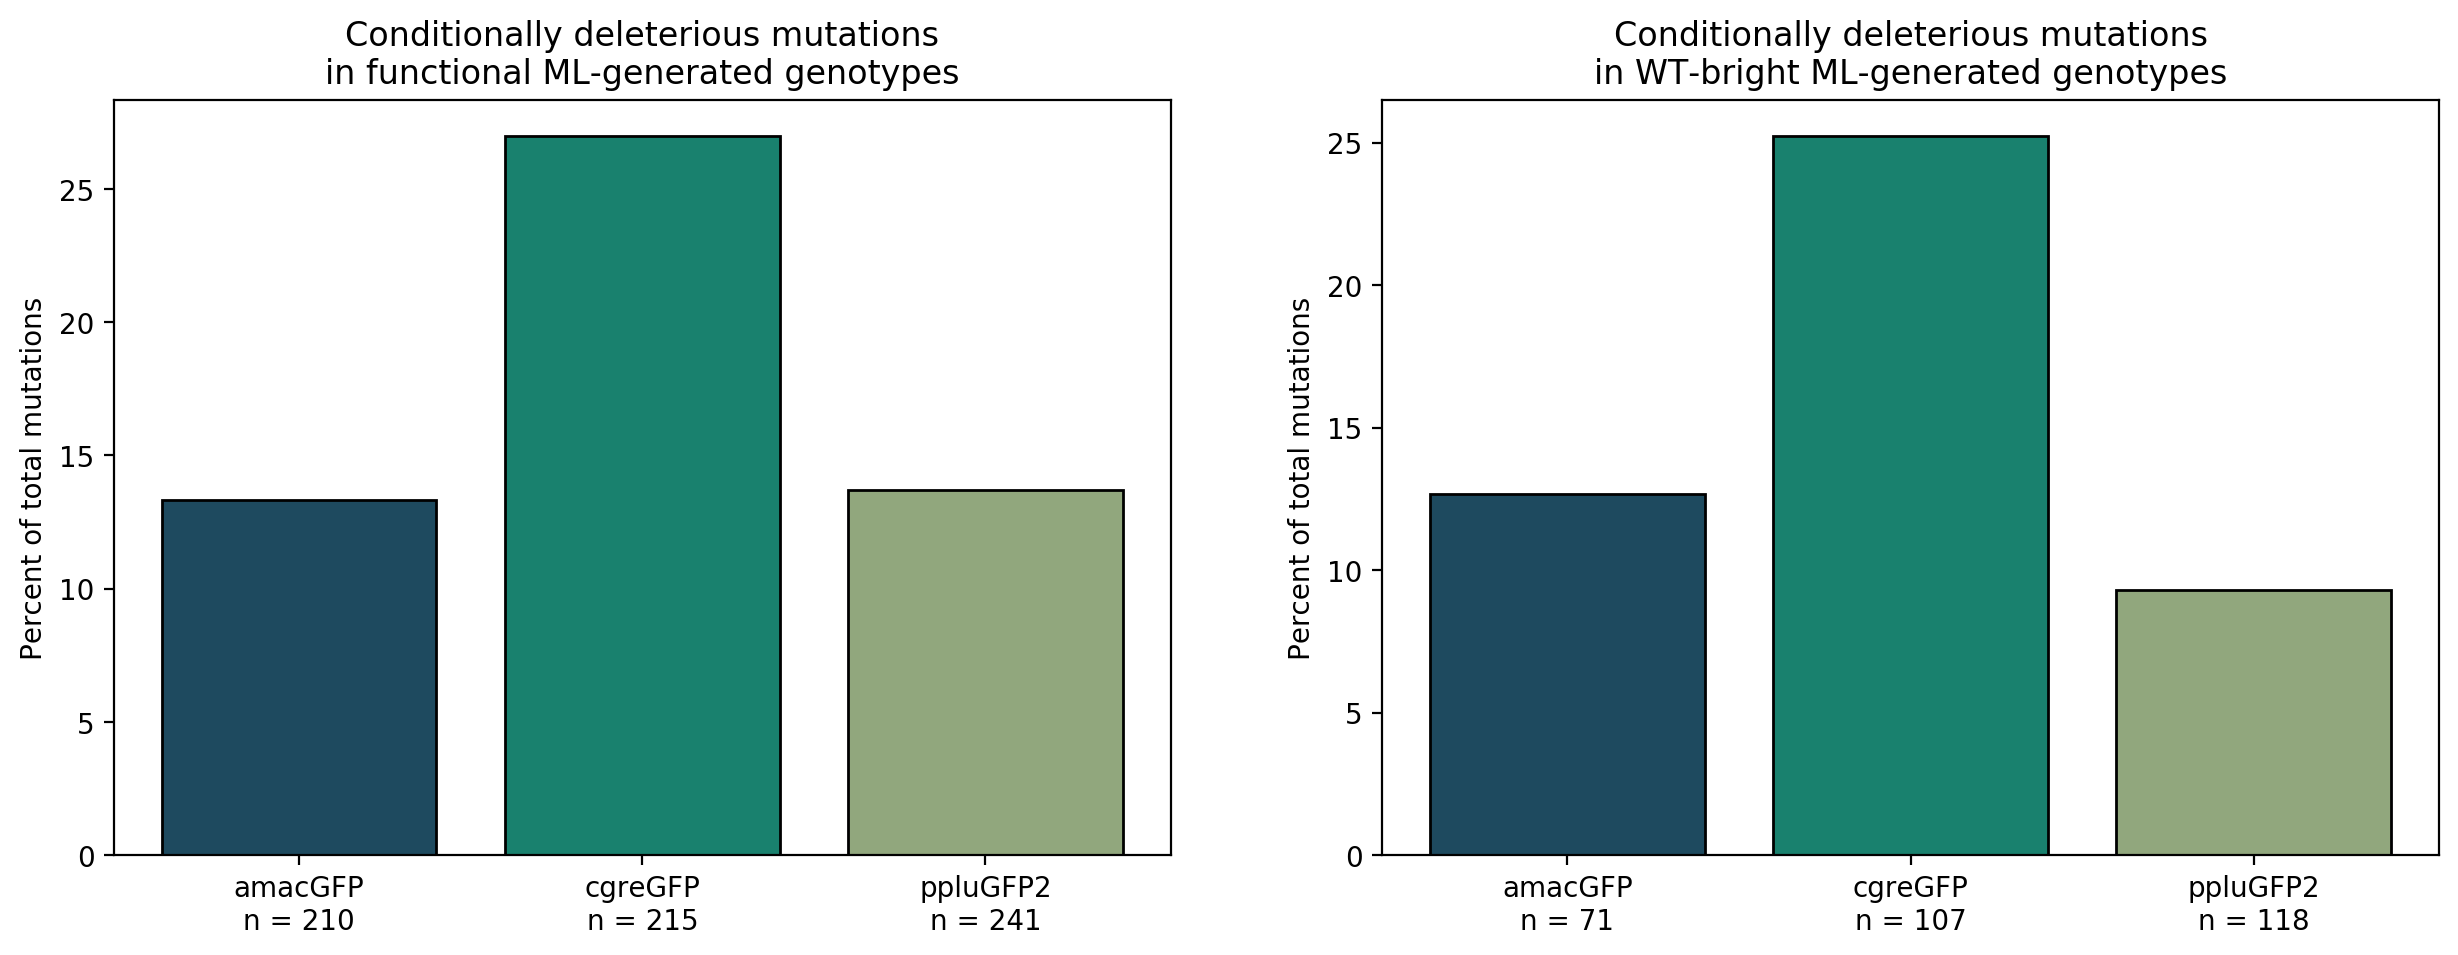

In [24]:
plt.figure(figsize=[15,5], dpi=200)
plt.subplot(1,2,1)
plot_percent_cond_del_muts(['amac','cgre','pplu'], fitmin='functional')
plt.subplot(1,2,2)
plot_percent_cond_del_muts(['amac','cgre','pplu'], fitmin='WT-bright')

### Worst potential effects of mutations in successful ML genotypes

In [25]:
def get_worst_effect(mut, gene, d = bg_data):
    if mut in d[gene]:
        return d[gene][mut]['mut_effect'].min()
    else:
        return np.nan
    
def get_worst_effect_multi(genotype, gene, d = bg_data):
    genotype = genotype.split(':')
    worsts = []
    for mut in genotype:
        worsts.append(get_worst_effect(mut, gene, d))
    return np.nanmin(worsts)

def get_worst_effect_multi_average(genotype, gene, d = bg_data):
    genotype = genotype.split(':')
    worsts = []
    for mut in genotype:
        worsts.append(get_worst_effect(mut, gene, d))
    return np.nanmean(worsts)

In [26]:
predictions['worst_mut_effect'] = predictions[['aa_genotype_pseudo','gene']].apply(lambda x:
                                                    get_worst_effect_multi(genotype = x[0], gene=x[1]+'GFP'),
                                                                                  axis=1)

In [27]:
predictions['expectation_if_worst'] = predictions[['gene','worst_mut_effect']].apply(lambda x:
                                                ref_wt_log[x[0]+'GFP'] + x[1], axis=1)

In [28]:
def scatter_worstmut_vs_fitness(gene):

    sns.scatterplot(data = predictions[predictions.gene==gene], y = 'fiji_library_values', 
                    x = 'worst_mut_effect', 
                    marker='o', #hue='distance'
                    color=colors[gene], edgecolor='w' , s=50)
    plt.ylabel('Fluorescence (log)')
    plt.xlabel('Worst known mutation effect')
    plt.title(f'{names[gene]}\nML-generated genotypes')
        
    plt.axhline(gate_borders_log[gene][0], color='crimson', linestyle='--', linewidth=1)

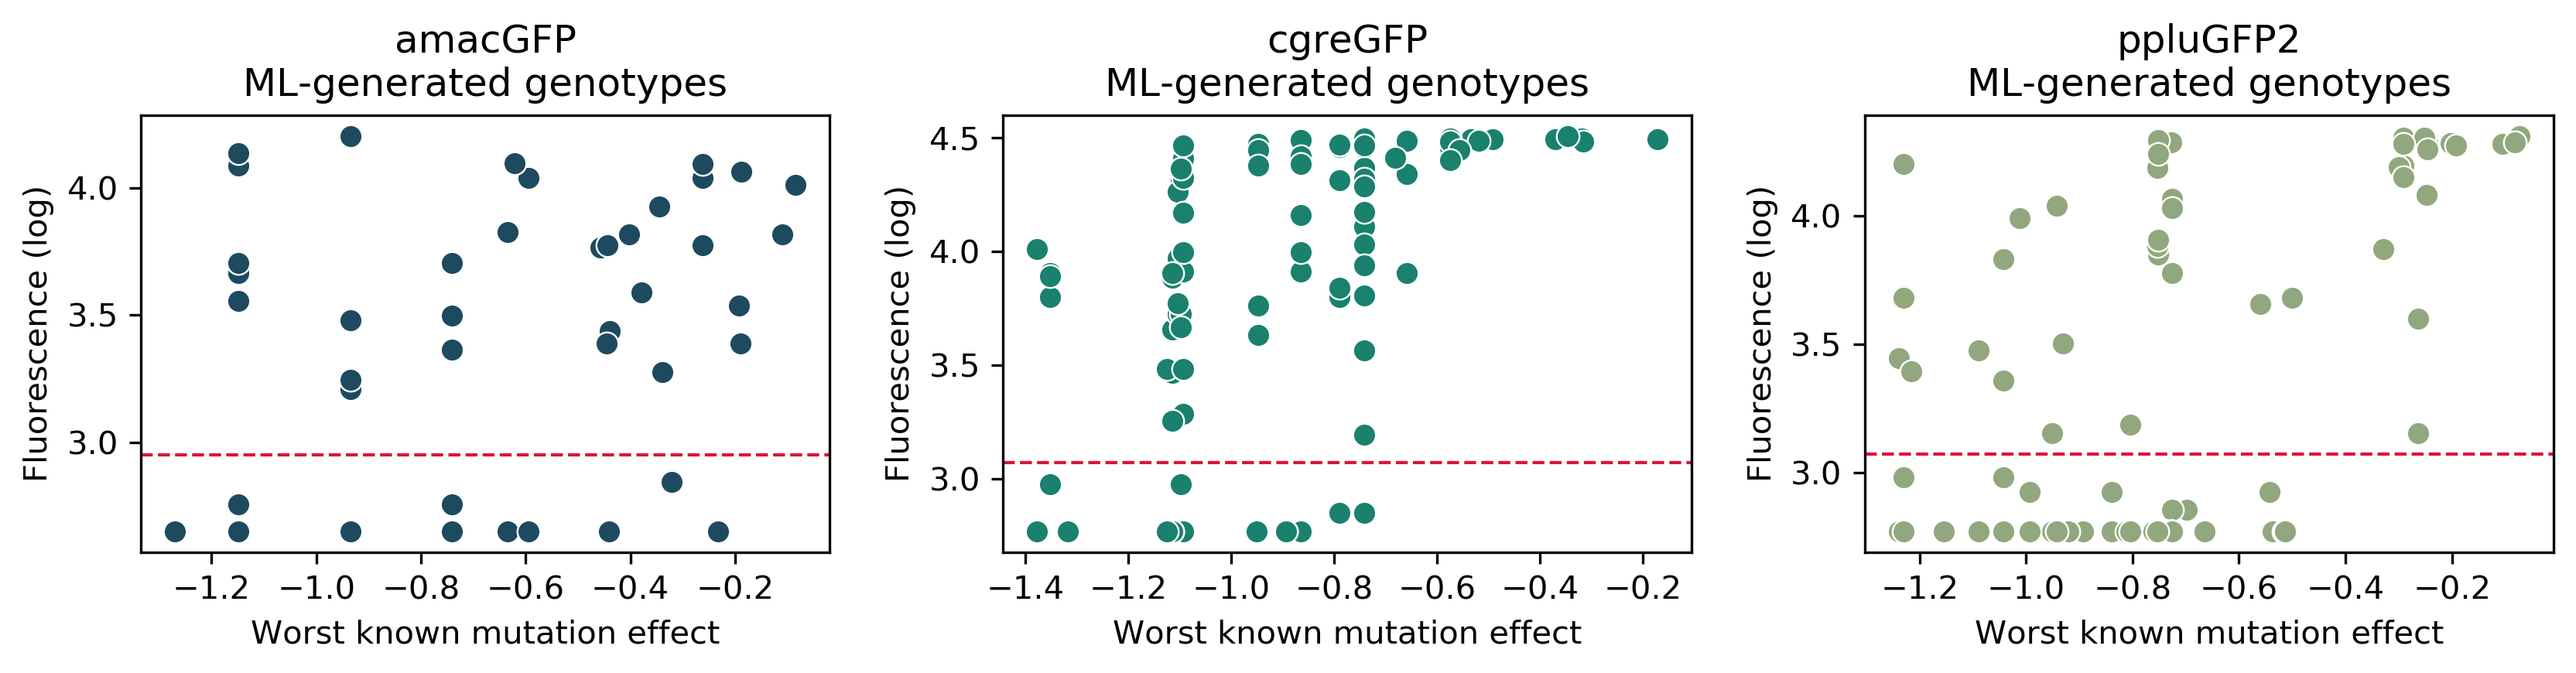

In [29]:
plt.figure(figsize=[15,3], dpi=300)

for i,g in zip([1,2,3], ['amac','cgre','pplu']):
    plt.subplot(1,4,i)
    scatter_worstmut_vs_fitness(g)
    
plt.tight_layout()